In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
import matplotlib.font_manager as fm

# 1️⃣ 설치된 한글 폰트 확인
fm.findSystemFonts(fontpaths=None, fontext='ttf')

# 2️⃣ 한글 폰트 지정 (예:AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'

# 3️⃣ 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 줄임말 없이 전체를 출력하려면 **pd.set_option**을 사용
pd.set_option('display.max_rows', None)     # 행 모두 표시
pd.set_option('display.max_columns', None)  # 열 모두 표시
pd.set_option('display.max_colwidth', None) # 컬럼 내용 길이 제한 해제
pd.set_option('display.expand_frame_repr', False) # 한 줄에 다 표시

In [5]:
# =====================================================
# 1. 데이터 로드
# =====================================================
train_df = pd.read_csv("./data/train.csv")
test_df  = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")

In [6]:
df = train_df.copy()
target = '임신 성공 여부'

In [7]:
# 삭제 컬럼 (안전하게)
drop_cols = [c for c in df.columns if c in ['ID', '시술 시기 코드', '임신 시도 또는 마지막 임신 경과 연수', '난자 해동 경과일', '배아 해동 경과일']]
df = df.drop(columns=drop_cols)

In [8]:
# 범주형 컬럼 지정
categorical_cols = ['시술 당시 나이','시술 유형','특정 시술 유형','배란 유도 유형','배아 생성 주요 이유',
    '난자 출처','정자 출처','난자 기증자 나이','정자 기증자 나이'
]

# 수치형 변환 (문자형 숫자 → int)
num_cols = ['총 시술 횟수','클리닉 내 총 시술 횟수','IVF 시술 횟수','DI 시술 횟수',
            '총 임신 횟수','IVF 임신 횟수','DI 임신 횟수','총 출산 횟수','IVF 출산 횟수','DI 출산 횟수']

In [9]:

# 숫자가 포함된 문자열 데이터에서 숫자만 추출하는 함수 및 적용코드
import re
def extract_number(x):
    if pd.isna(x):
        return 0
    num = re.findall(r'\d+', str(x))
    if num:
        return int(num[0])
    else:
        return 0

for col in num_cols:
    if col in df.columns:
        df[col] = df[col].apply(extract_number)

In [10]:
# 결측치 처리 함수
def fill_missing(df, cat_cols, num_cols):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # 숫자형 결측치
    for col in num_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)
#             df[col] = df[col].fillna(df[col].mean())
            
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # 범주형 결측치 + 타입 변환 + 문자열 처리
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')
            df[col] = df[col].astype('category')
            # 문자열이면 소문자 + strip
#             if df[col].dtype.name == 'category' or df[col].dtype == object:
#                 df[col] = df[col].astype(str).str.lower().str.strip()

                
    return df

In [11]:
# Rare category 통합 함수
def rare_category(df, cat_cols, threshold=0.01):
    for col in cat_cols:
        freq = df[col].value_counts(normalize=True)
        rare = freq[freq < threshold].index
        df[col] = df[col].replace(rare, 'Other')
        df[col] = df[col].astype('category')
    return df

In [12]:
# 1. 시술 대비 임신/출산 비율
# def feature_success_rate(df):
def feature_1(df):
    df = df.copy()
    df['IVF_success_rate'] = df['IVF 임신 횟수'].astype(float) / (df['IVF 시술 횟수'].astype(float) + 1e-5)
    df['DI_success_rate'] = df['DI 임신 횟수'].astype(float) / (df['DI 시술 횟수'].astype(float) + 1e-5)
    df['total_birth_rate'] = df['총 출산 횟수'].astype(float) / (df['총 시술 횟수'].astype(float) + 1e-5)
    return df

# 2. 난자/배아 관련 상호작용
# def feature_embryo_interaction(df):
def feature_2(df):
    df = df.copy()
    df['embryo_transfer_rate'] = df['이식된 배아 수'].astype(float) / (df['총 생성 배아 수'].astype(float) + 1e-5)
    df['micro_inj_transfer_rate'] = df['미세주입 배아 이식 수'].astype(float) / (df['미세주입에서 생성된 배아 수'].astype(float) + 1e-5)
    df['frozen_use_rate'] = df['동결 배아 사용 여부'] / (df['저장된 배아 수'].astype(float) + 1e-5)
    return df

# 3. 연령 관련 숫자화
# def feature_age_numeric(df):
def feature_3(df):
    df = df.copy()
    def age_str_to_mid(age_str):
        if age_str in ['알 수 없음', 'Unknown']:
            return np.nan
        try:
            parts = age_str.replace('만','').replace('세','').split('-')
            return (int(parts[0]) + int(parts[1])) / 2
        except:
            return np.nan

    df['시술 당시 나이_num'] = df['시술 당시 나이'].apply(age_str_to_mid)
    df['난자 기증자 나이_num'] = df['난자 기증자 나이'].apply(age_str_to_mid)
    df['정자 기증자 나이_num'] = df['정자 기증자 나이'].apply(age_str_to_mid)
    return df

# 4. 불임 원인 합계
# def feature_total_infertility(df):
def feature_4(df):
    df = df.copy()
    infertility_cols = [
        '남성 주 불임 원인','남성 부 불임 원인','여성 주 불임 원인','여성 부 불임 원인',
        '부부 주 불임 원인','부부 부 불임 원인','불명확 불임 원인','불임 원인 - 난관 질환',
        '불임 원인 - 남성 요인','불임 원인 - 배란 장애','불임 원인 - 자궁경부 문제',
        '불임 원인 - 자궁내막증','불임 원인 - 정자 농도','불임 원인 - 정자 면역학적 요인',
        '불임 원인 - 정자 운동성','불임 원인 - 정자 형태'
    ]
    df['total_infertility_factors'] = df[infertility_cols].sum(axis=1)
    return df

# 5. 시술 타입 + 배란 자극 여부 결합
# def feature_type_stim(df):
def feature_5(df):
    df = df.copy()
    df['IVF_stim'] = ((df['시술 유형']=='IVF') & (df['배란 자극 여부']==1)).astype(int)
    df['DI_stim'] = ((df['시술 유형']=='DI') & (df['배란 자극 여부']==1)).astype(int)
    return df


In [16]:
# ======================
# 3. Ablation 실험 준비
# ======================
ablation_steps = {
    'no_feature_1': lambda df: feature_5(feature_4(feature_3(feature_2(df)))),
    'no_feature_2': lambda df: feature_5(feature_4(feature_3(feature_1(df)))),
    'no_feature_3': lambda df: feature_5(feature_4(feature_2(feature_1(df)))),
    'no_feature_4': lambda df: feature_5(feature_3(feature_2(feature_1(df)))),
    'no_feature_5': lambda df: feature_4(feature_3(feature_2(feature_1(df)))),
    'feature_all' : lambda df: feature_5(feature_4(feature_3(feature_2(feature_1(df))))),
}

# ablation_steps = {
#     'success_rate': lambda df: feature_success_rate(df),
#     'embryo_interaction': lambda df: feature_embryo_interaction(df),
#     'age_numeric': lambda df: feature_age_numeric(df),
#     'total_infertility': lambda df: feature_total_infertility(df),
#     'type_stim': lambda df: feature_type_stim(df),
# }

In [17]:
# ======================
# 4. K-Fold OOF 학습
# ======================
folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
results = {}

# 기존 preprocessing 유지
df_base = rare_category(fill_missing(df.copy(), categorical_cols, num_cols), categorical_cols)

for name, feature_fn in ablation_steps.items():
    print(f"========== {name} ==========")
    
    # 기존 df + 새로운 피쳐 추가
    df_proc = feature_fn(df_base)
    
    X = df_proc.drop(columns=target)
    y = df_proc[target]
    
    # 숫자형 + 범주형 구분
    num_cols_proc = X.select_dtypes(include=['int64','float64']).columns.tolist()
    cat_cols_proc = X.select_dtypes(include=['category','object']).columns.tolist()
    
    oof_preds = np.zeros(len(df))
    
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_proc)
        valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_proc, reference=train_data)
        
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'seed': 42
        }
        
        model = lgb.train(
            params,
            train_data,
            num_boost_round=1000,
            valid_sets=[valid_data],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        
        oof_preds[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
    
    oof_auc = roc_auc_score(y, oof_preds)
    results[name] = oof_auc
    print(f"{name} OOF AUC: {oof_auc:.5f}\n")

print("=== 피쳐별 Ablation 결과 ===")
print(results)

========== no_feature_1 ==========
no_feature_1 OOF AUC: 0.73890

========== no_feature_2 ==========
no_feature_2 OOF AUC: 0.73907

========== no_feature_3 ==========
no_feature_3 OOF AUC: 0.73875

========== no_feature_4 ==========
no_feature_4 OOF AUC: 0.73877

========== no_feature_5 ==========
no_feature_5 OOF AUC: 0.73882

========== feature_all ==========
feature_all OOF AUC: 0.73883

=== 피쳐별 Ablation 결과 ===
{'no_feature_1': 0.7388981109100786, 'no_feature_2': 0.7390683860783955, 'no_feature_3': 0.7387456651191522, 'no_feature_4': 0.7387733940586403, 'no_feature_5': 0.7388171103342571, 'feature_all': 0.7388266994479932}


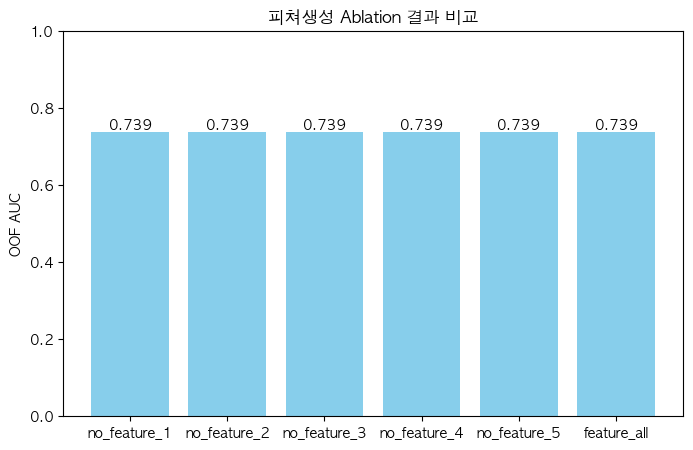

In [18]:
# ======================
# 5. Ablation 시각화
# ======================
plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("OOF AUC")
plt.title("피쳐생성 Ablation 결과 비교")
plt.ylim(0,1)
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center')
plt.show()

In [19]:
results.values()

dict_values([0.7388981109100786, 0.7390683860783955, 0.7387456651191522, 0.7387733940586403, 0.7388171103342571, 0.7388266994479932])